## Outline

To specify a simulation, one needs to provide:

* total simulation time `total_time`  
* simulations start and end times `stim_start` and `stim_end`
* reward function evaluation time `eval_time`
* a reward function `reward_func` mapping rates to a reward variable
* (optional) a reward derivative `dR_dt`
* (for plasticity) `plasticity_parameters` for the plasticity rule
* (for repeated trials) the starting weight matrix `W`

### Testing [simulation.py](./simulation.py) Below

TODO:  

* implement EA with `plasticity_params`

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
from simulation import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [58]:
W_new = get_weights()
theta = None

In [59]:
## everything becomes NaNs
for i in tqdm(range(50)):
    coherence = np.random.choice([-0.7, 0.7])
    results_dict = run_trial_coherence_2afc(
        total_time=2*runtime,
        coherence=coherence,
        theta=theta,
        W=W_new,
        use_phi_fitted=True,
        plasticity=True
    )
    if np.any(np.isnan(results_dict['W'])):
        print(f'Encountered NaNs on iteration {i}')
        break
    W_new = results_dict['W'][:,:,-1].copy()
    theta = results_dict['theta'][:, -1].copy()

100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


In [159]:
from functools import partial
from tqdm.notebook import tqdm

# step 0: set initial conditions
W_initial = get_weights()

# step 1: specify trial
# coherence shouldn't be specified in general,
# but it is here just for consistency
trial_func = partial(
    run_trial_coherence_2afc,
    total_time=2*runtime,
    coherence=0.068,
    use_phi_fitted=True
)

# step 2: have the genome ready
plasticity_params = nolearn_parameters

# step 3: 
def run_repeated_trial(
    W_initial, plasticity_params,
    n_runs=10,
    verbose=False
):
    W = W_initial
    theta = None
    full_results_dict = dict()
    
    iterable = range(n_runs)
    if verbose:
        iterable = tqdm(iterable)
    for i in iterable:
        results_dict = trial_func(
            W=W,
            theta=theta,
            plasticity_params=plasticity_params
        )
        W = results_dict["W"][:, :, -1]
        theta = results_dict["theta"][:, -1]
        if i == 0:
            for k, v in results_dict.items():
                full_results_dict[k] = [v]
        else:
            for k, v in results_dict.items():
                full_results_dict[k].append(v)
    return full_results_dict

n_runs = 5
full_results_dict = run_repeated_trial(
    W_initial=W_initial,
    plasticity_params=plasticity_params,
    n_runs=n_runs,
    verbose=True
)

  0%|          | 0/5 [00:00<?, ?it/s]

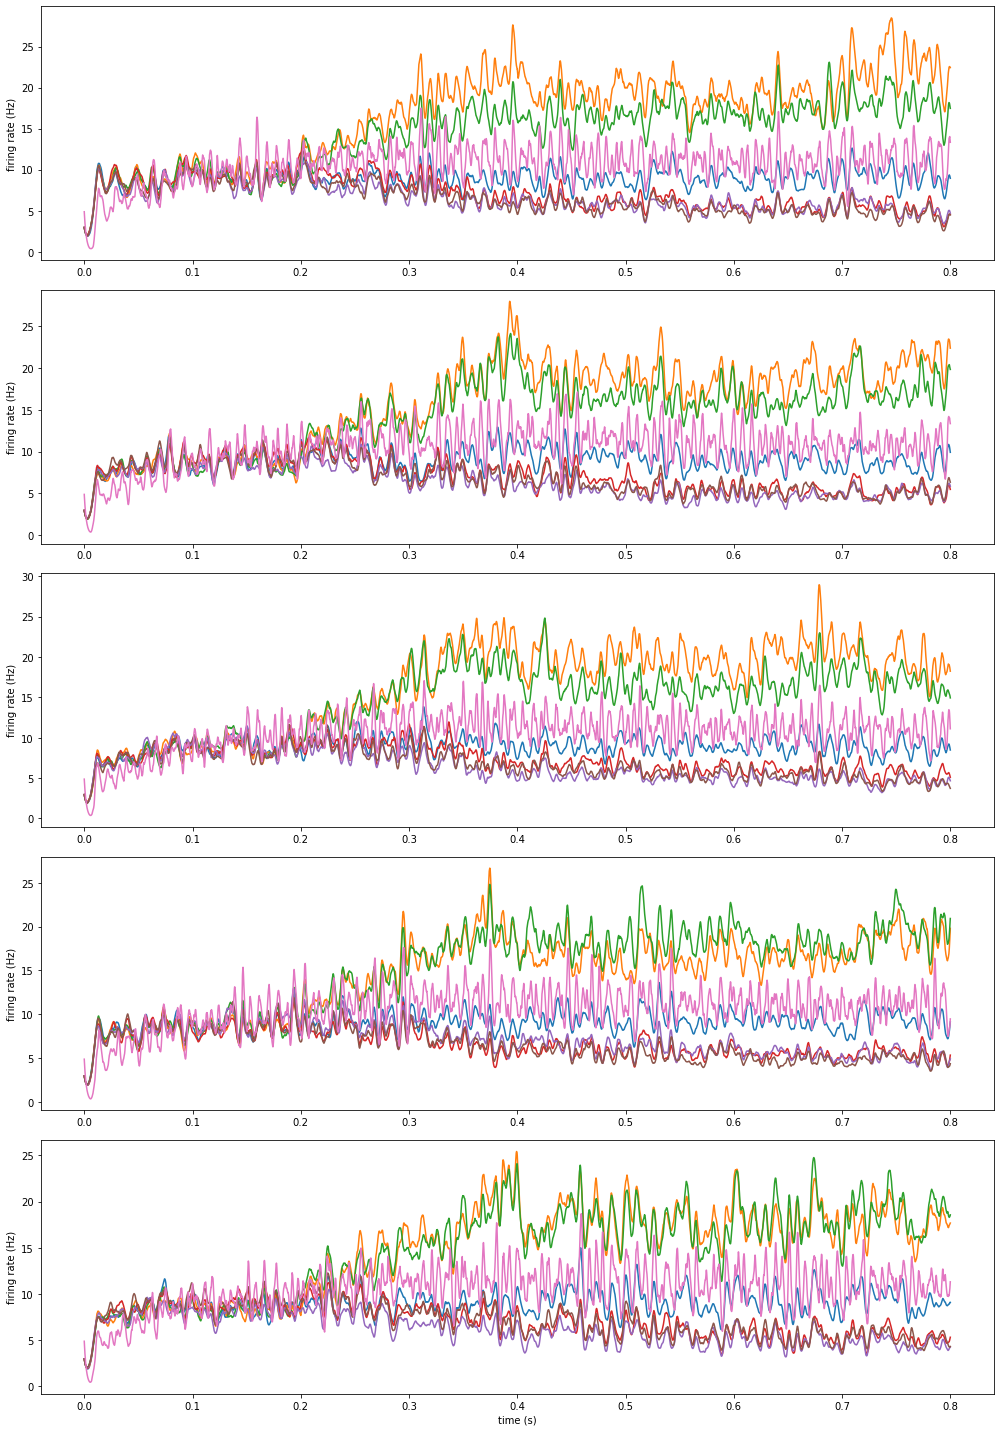

In [160]:
fig, axes = plt.subplots(n_runs, figsize=(14, n_runs*4))

for i in range(n_runs):
    nu = full_results_dict['nu'][i]
    times = full_results_dict['times'][i]
    for j in range(p+2):
        axes[i].plot(times, nu[j, :])
    axes[i].set_ylabel('firing rate (Hz)')
axes[-1].set_xlabel('time (s)')
fig.tight_layout()

In [161]:
np.sum(full_results_dict['reward'])

35.0

In [204]:
# step 4: run several iterations of repeated trials
# and sum reward values to get a fitness score
# TODO: handle NaNs
# what happens if NaNs only happen on a later run,
# do I replace all fitness values or just that run?
# Rewards won't be NaNs, so looking at rewards won't
# determine if the simulation breaks
def get_fitness(
    W_initial, plasticity_params,
    n_runs=5,
    n_multiples=5,
    verbose=False
):
    # TODO: parallelise this:
    fitness = 0.0
    for i in range(n_multiples):
        results_dict = run_repeated_trial(
            W_initial=W_initial,
            plasticity_params=plasticity_params,
            n_runs=n_runs,
            verbose=verbose
        )
#         fitness += np.sum(results_dict['reward'])
        for rew_array in results_dict['reward']:
            if not np.any(np.isnan(rew_array)):
                fitness += np.sum(rew_array)
    fitness = fitness / n_multiples  # get the average across restarts
    return fitness  # this must be a tuple for the EA

In [233]:
import dask.bag as db

b = db.from_sequence([1,2,3])
b.map(lambda x:x**2).compute()

[1, 4, 9]

In [162]:
fitness = get_fitness(
    W_initial, plasticity_params,
    n_runs=10, n_multiples=10,
    verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [205]:
fitness

574.0

In [206]:
@jit(nopython=True)
def get_params_from_genome(genome):
    """Genome must be passed in as a numpy array for the jit."""
    params = genome.copy()
    
    p_theta_unbounded = genome[1]  # \in [1, \infty)
    mu_unbounded = genome[2]  # \in [0, 1]
    tau_theta_unbounded = genome[3]  # \in R^+
    tau_e_unbounded = genome[-2]  # \in R^+
    beta_unbounded = genome[-1]  # \in [0, 1]
    
    p_theta = 1+softplus(p_theta_unbounded)
    mu = sigmoid(mu_unbounded)
    tau_theta = softplus(tau_theta_unbounded)
    tau_e = softplus(tau_e_unbounded)
    beta = sigmoid(beta_unbounded)
    
    params[1] = p_theta
    params[2] = mu
    params[3] = tau_theta
    params[-2] = tau_e
    params[-1] = beta
    return params
    
@jit(nopython=True)
def sigmoid(x):
    return 1./(1+np.exp(-x))

@jit(nopython=True)
def softplus(x):
    return np.log(1+np.exp(x))

In [207]:
nolearn_parameters = (
    0.,1.,0.5,100.,0.,0.,0.,0.,0.,0.,
    0.,0.,0.,0.,0.,0.,0.,0.,0.,100.,0.5
)
nolearn_genome = [
    0.,-10.,0.,100.,0.,0.,0.,0.,0.,0.,
    0.,0.,0.,0.,0.,0.,0.,0.,0.,100.,0.
]

np.array(nolearn_parameters) - get_params_from_genome(np.array(nolearn_genome))
# close enough

array([ 0.00000000e+00, -4.53988992e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [240]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import cma

import dask.multiprocessing
from dask import delayed, compute
dask.config.set(scheduler='processes')
from multiprocessing.pool import ThreadPool

def map_dask(f, *iters):
    """
    Following the solution here: 
    https://stackoverflow.com/questions/42051318/programming-deap-with-scoop
    
    Use with `toolbox.register("map", map_dask)`
    """
    f_delayed = delayed(f)
    return compute([f_delayed(*args) for args in zip(*iters)])
    
    
W_initial = get_weights()
def fitness_EA(genome):  # notice no W_initial... should this be a partial func?
    plasticity_params = get_params_from_genome(
        np.array(genome)
    )
    return get_fitness(
        W_initial=W_initial,
        plasticity_params=plasticity_params),

initial_centroid = nolearn_genome


creator.create("FitnessMax", base.Fitness, weights=(1.,))
creator.create("Individual", list, fitness=creator.FitnessMax)

NGEN = 5  # to test

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

strategy = cma.Strategy(
    centroid=initial_centroid,
    sigma=0.0001
)

hof = tools.HallOfFame(10)

toolbox = base.Toolbox()
toolbox.register("evaluate", fitness_EA)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)
# toolbox.register("map", map_dask)

In [238]:
fitness_EA(toolbox.generate()[0]), fitness_EA(initial_centroid)

((7.0,), (119.0,))

In [ ]:
# %%time
# with dask.config.set(pool=ThreadPool(10)):
pop, logbook = algorithms.eaGenerateUpdate(
    toolbox,
    ngen=10,
    stats=stats,
    halloffame=hof,
    verbose=True
)

gen	nevals	avg     	std    	min	max
0  	13    	-1.61538	56.8785	-77	147
